In [1]:
import pandas as pd
import os
# Define paths to your extracted files
style_class_path = r'C:\Users\dmin\HUST\Projects\Artstyle classification\wikiart_csv\style_class.txt'
style_train_path = r'C:\Users\dmin\HUST\Projects\Artstyle classification\wikiart_csv\style_train.csv'
style_val_path = r'C:\Users\dmin\HUST\Projects\Artstyle classification\wikiart_csv\style_val.csv'

# Load the style class
style_class = {}
with open(style_class_path, 'r') as file:
    for line in file:
        key, value = line.strip().split()
        style_class[int(key)] = value

# Load the train and validation data
train_df = pd.read_csv(style_train_path, header=None, names=['filepath', 'label'])
val_df = pd.read_csv(style_val_path, header=None, names=['filepath', 'label'])

train_df.head(10)


,filepath,label
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12
5,Cubism/candido-portinari_chorinho-1942.jpg,7
6,Art_Nouveau_Modern/gustav-klimt_the-tree-of-li...,3
7,Symbolism/ion-theodorescu-sion_ovid-in-exile-1...,24
8,Romanticism/william-turner_pope-s-villa-at-twi...,23
9,Color_Field_Painting/gene-davis_tarzan-series-...,5


# Create Dataset

Missing files (2):
['Baroque/rembrandt_woman-standing-with-raised-hands.jpg', 'Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg']


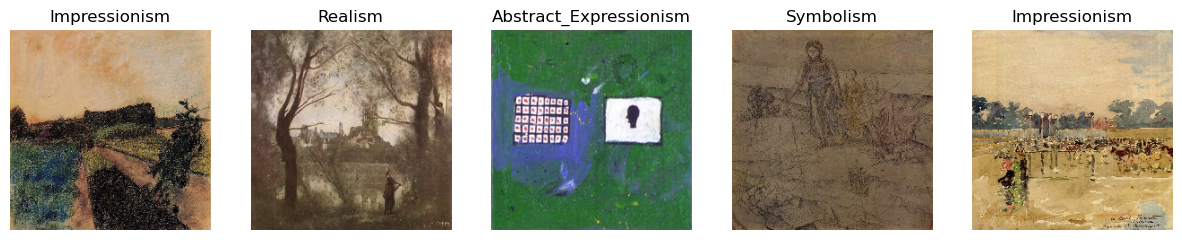

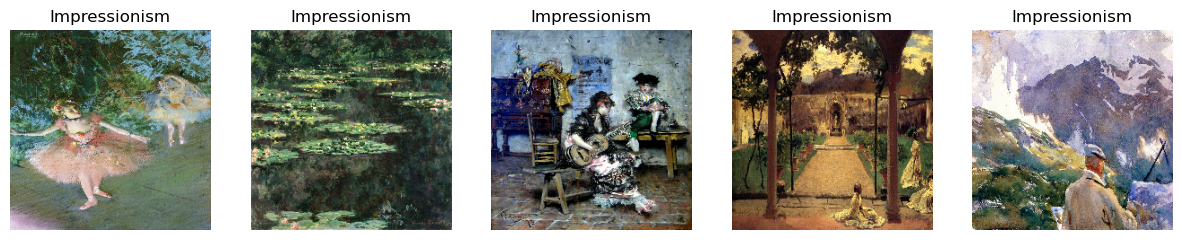

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt



# Define the base directory for images
wikiart_dir = r'C:\Users\dmin\HUST\Projects\Artstyle classification\wikiart\wikiart'

# Check if all file paths exist
missing_files = []
for filepath in train_df['filepath']:
    full_path = os.path.join(wikiart_dir, filepath)
    if not os.path.exists(full_path):
        missing_files.append(filepath)

if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    print(missing_files)
else:
    print("All files are present.")

train_df = train_df[~train_df['filepath'].isin(missing_files)]

def load_image(filepath, label):
    image = tf.io.read_file(tf.strings.join([wikiart_dir, filepath], separator=os.path.sep))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to a standard size
    image = image / 255.0  # Normalize to [0, 1] range
    return image, label

# Function to create a dataset from a DataFrame
def create_dataset(dataframe,batch_size = 16):
    filepaths = dataframe['filepath'].values
    labels = dataframe['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda filepath, label: load_image(filepath, label),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create train dataset
batch_size = 32
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)


# Display some images and their labels
def display_images(dataset, num_images):
    plt.figure(figsize=(15, 15))
    count = 0
    for batch in dataset:
        images, labels = batch
        for i in range(len(images)):
            if count >= num_images:
                break
            plt.subplot(1, num_images, count + 1)
            plt.imshow(images[i].numpy())
            plt.title(style_class[labels[i].numpy()])
            plt.axis('off')
            count += 1
        if count >= num_images:
            break
    plt.show()

# Display 5 images and their labels from the training set
display_images(train_dataset, 5)
display_images(val_dataset,5)

In [21]:
def checkHowManyLabelsInADataSet(dataset):
    seen_labels = set()
    for i,(img,label) in enumerate(dataset):
        if label.numpy() not in seen_labels:
            seen_labels.add(label.numpy())
        else:
            continue
    return len(seen_labels)

# Count the number of elements in the TensorFlow dataset
num_elements = train_dataset.reduce(0, lambda x, _: x + 1).numpy()
print(f"Number of images in the training dataset: {num_elements}")
print(f"Number of labels in the training dataset: {checkHowManyLabelsInADataSet(train_dataset)}")
num_elements_val_set = val_dataset.reduce(0, lambda x, _: x + 1).numpy()
print(f"Number of images in the testing dataset: {num_elements_val_set}")
print(f"Number of labels in the testing dataset: {checkHowManyLabelsInADataSet(val_dataset)}")

Number of images in the training dataset: 57023
Number of labels in the training dataset: 27
Number of images in the testing dataset: 24421
Number of labels in the testing dataset: 27


## 57023 images in the training set, 24421 images in the testing set. The ratio is 70/30

# Building the model

In [3]:
from tensorflow.keras import layers, models

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(style_class), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=10,
    )



Epoch 1/10


c:\Users\dmin\anaconda3\anaconda\envs\test_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3564/3564 ━━━━━━━━━━━━━━━━━━━━ 942s 264ms/step - accuracy: 0.2043 - loss: 2.7109 - val_accuracy: 0.2728 - val_loss: 2.3271
Epoch 2/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 891s 250ms/step - accuracy: 0.3185 - loss: 2.1588 - val_accuracy: 0.3070 - val_loss: 2.2735
Epoch 3/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 869s 244ms/step - accuracy: 0.4634 - loss: 1.6599 - val_accuracy: 0.2816 - val_loss: 2.7567
Epoch 4/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 868s 244ms/step - accuracy: 0.6726 - loss: 1.0139 - val_accuracy: 0.2563 - val_loss: 3.8376
Epoch 5/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 878s 246ms/step - accuracy: 0.8153 - loss: 0.6001 - val_accuracy: 0.2313 - val_loss: 4.9993
Epoch 6/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 902s 253ms/step - accuracy: 0.8742 - loss: 0.4268 - val_accuracy: 0.2254 - val_loss: 6.0911
Epoch 7/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 882s 248ms/step - accuracy: 0.9111 - loss: 0.3204 - val_accuracy: 0.2275 - val_loss: 6.9508
Epoch 8/10
3564/3564 ━━━━━━━━━━━━━━━━━━━━ 891s 250ms/step - accuracy: 0.9

### Learning curves

# Inference

In [12]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
def inference(path,model_chosen):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f)
        img = img.resize((224,224))
    img_array = np.array(img)  # Convert image to numpy array
    img_array = img_array / 255.0  # Normalize the image to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0) 

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    return predictions


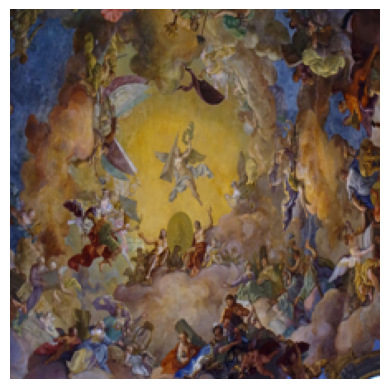

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: [[1.0573756e-05 3.6571379e-10 1.1962289e-12 1.9636693e-04 1.9568663e-06
  4.0497957e-07 1.9872701e-07 1.8555248e-06 6.9626680e-08 4.5835643e-04
  6.9616331e-06 3.4478621e-08 1.9347280e-02 4.6495852e-10 1.4718506e-07
  3.4472739e-06 7.1339491e-07 5.6987319e-06 1.8519607e-08 1.2102531e-09
  4.5841057e-06 1.7275893e-04 2.4433959e-07 1.9570829e-04 9.7959250e-01
  2.3084570e-13 4.4004449e-13]]


In [13]:
path = "https://wallpapercave.com/wp/wp4549348.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f)
    img = img.resize((224,224))
    x = np.array(img) / 255.0
plt.imshow(x)
plt.axis('off')
plt.show()
result = inference(path, model)
print("Predicted class:", result)

In [14]:
print("Current working directory:", os.getcwd())

# Save the model
model.save('first_cnn_artstyle_classification_model_25072024.h5')

Current working directory: c:\Users\dmin\HUST\Projects\Artstyle classification
